In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

In [2]:
from test_sim_utils import Sim, TEST_METADETECT_CONFIG

In [3]:
from metadetect.metadetect_and_cal import MetadetectAndCal
from metadetect.metadetect import Metadetect

config = {}
config.update(TEST_METADETECT_CONFIG)

In [ ]:
def _meas_shear(res):
    op = res['1p']
    q = (op['flags'] == 0) & (op['wmom_s2n'] > 10) & (op['wmom_T_ratio'] > 1.2)
    g1p = op['wmom_g'][q, 0]
    
    om = res['1m']
    q = (om['flags'] == 0) & (om['wmom_s2n'] > 10) & (om['wmom_T_ratio'] > 1.2)
    g1m = om['wmom_g'][q, 0]
    
    o = res['noshear']
    q = (o['flags'] == 0) & (o['wmom_s2n'] > 10) & (o['wmom_T_ratio'] > 1.2)
    g1 = o['wmom_g'][q, 0]
    
    return g1p, g1m, g1

from scipy.optimize import curve_fit

def _get_stuff(rr):
    g1p = np.array([np.mean(r[0]) for r in rr])
    g1m = np.array([np.mean(r[1]) for r in rr])
    g1 = np.array([np.mean(r[2]) for r in rr])
    
    return g1, (g1p - g1m) / 2 / 0.01 * 0.02

def _fit_m(prr, mrr):
    g1p, R11p = _get_stuff(prr)
    g1m, R11m = _get_stuff(mrr)
    
    x = R11p + R11m
    y = g1p - g1m
    
    fres = curve_fit(lambda x, m: (1 + m) * x, x, y, [0])
    return fres[0][0], np.sqrt(fres[1][0, 0])

In [ ]:
import tqdm

offset = 12

with tqdm.trange(20) as itr:
    pres = []
    mres = []
    for i in itr:
        rng = np.random.RandomState(seed=i+offset)
        mbobs = Sim(rng, config={'g1': 0.02}).get_mbobs()
        md = Metadetect(config, mbobs, rng)
        md.go()
        pres.append(_meas_shear(md.result))

        rng = np.random.RandomState(seed=i+offset)
        mbobs = Sim(rng, config={'g1': -0.02}).get_mbobs()
        md = Metadetect(config, mbobs, rng)
        md.go()
        mres.append(_meas_shear(md.result))

In [ ]:
print("m: %f +/- %f" % _fit_m(pres, mres))

In [4]:
rng = np.random.RandomState(seed=0)

4


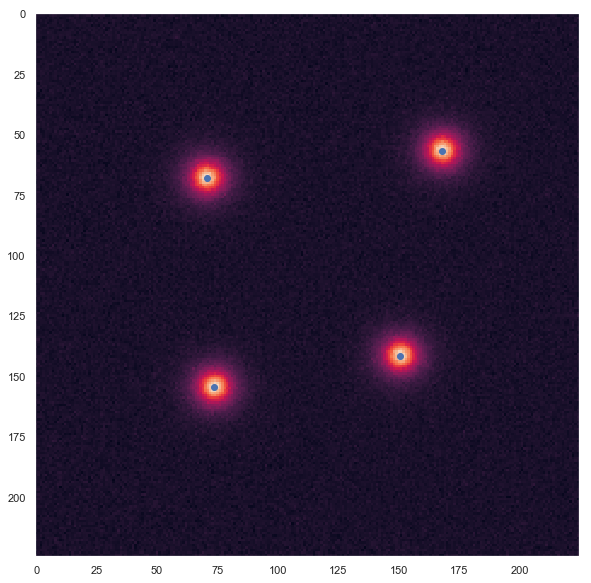

In [8]:
mbobs = Sim(rng, config={'g1': 0.02}).get_mbobs()
md = Metadetect(config, mbobs, rng)
md.go()

plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.imshow(mbobs[0][0].image)
ax.grid(False)

plt.plot(md.result['noshear']['sx_col'], md.result['noshear']['sx_row'], 'ob')

print(len(md.result['noshear']['sx_col']))